# **LOADING DATA**

In [1]:
# DRIVE --> LOCALLY ON COLAB

from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/HAM.zip'
local_dir = '/tmp/HAM'  # Load Files Locally for Faster Uploading

if not os.path.exists(zip_path):
    print(f"ZIP file not found at {zip_path}. Please check the path.")
else:
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(local_dir)
        print(f"Files successfully extracted to {local_dir}.")
    except zipfile.BadZipFile:
        print("The ZIP file is corrupted or invalid.")


Mounted at /content/drive
Files successfully extracted to /tmp/HAM.


# **IMPORTING LIBRARIES**

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tqdm.notebook import tqdm
import cv2
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [3]:
torch.manual_seed(42)
np.random.seed(42)

# **TRANSFORMERS**

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(10),  # Randomly rotate images by a specified angle
    transforms.ToTensor(),          # Convert PIL images to tensors
    transforms.Normalize(mean=[0.7630, 0.5457, 0.5703], std=[0.0875, 0.1164, 0.1309])  # Normalize to improve training
])
test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7630, 0.5457, 0.5703], std=[0.0875, 0.1164, 0.1309])
])

# **DATA AUGMENTATION**

In [5]:
import os
import random
from PIL import Image
from torchvision import transforms
import torch

augmentation = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.ToPILImage()
])

path_type = ['train', 'val', 'test']

for path_type in path_type:
    input_dir = f'/tmp/HAM/HAM/DatasetHAM/{path_type}/malignant'
    output_dir = f'/tmp/HAM/HAM/DatasetHAM/{path_type}/malignant'
    os.makedirs(output_dir, exist_ok=True)

    # Number of images needed
    existing_images = len(os.listdir(input_dir))
    total_needed = len(os.listdir(f'/tmp/HAM/HAM/DatasetHAM/{path_type}/benign'))
    to_generate = total_needed - existing_images


    # Augmentation process
    images = os.listdir(input_dir)
    generated_count = 0

    for image_name in images:
      if generated_count >= to_generate:
        break

      img_path = os.path.join(input_dir, image_name)
      original_img = Image.open(img_path).convert("RGB")  # Load image

      # Generate augmented images
      for _ in range(5):  # Create 5 augmentations per image
          if generated_count >= to_generate:
              break

          augmented_img = augmentation(original_img)  # Apply augmentation
          save_path = os.path.join(output_dir, f"aug_{generated_count + 1}.jpg")
          augmented_img.save(save_path)
          generated_count += 1

    print(f"Generated {generated_count} augmented images for {path_type}/malignant.")

Generated 3969 augmented images for train/malignant.
Generated 916 augmented images for val/malignant.
Generated 1222 augmented images for test/malignant.


In [6]:
# OBSERVE THE RATIO  benign  /  malignant

print(f"{len(os.listdir('/tmp/HAM/HAM/DatasetHAM/train/benign'))}/{len(os.listdir('/tmp/HAM/HAM/DatasetHAM/train/malignant'))}")
print(f"{len(os.listdir('/tmp/HAM/HAM/DatasetHAM/val/benign'))}/{len(os.listdir('/tmp/HAM/HAM/DatasetHAM/val/malignant'))}")
print(f"{len(os.listdir('/tmp/HAM/HAM/DatasetHAM/test/benign'))}/{len(os.listdir('/tmp/HAM/HAM/DatasetHAM/test/malignant'))}")

5239/5239
1209/1209
1613/1613


# **DATASETS + DATALOADERS**

In [7]:
train_dataset = torchvision.datasets.ImageFolder(root='/tmp/HAM/HAM/DatasetHAM/train', transform=train_transform)
val_dataset = ImageFolder(root='/tmp/HAM/HAM/DatasetHAM/val', transform=test_val_transform)
test_dataset = ImageFolder(root='/tmp/HAM/HAM/DatasetHAM/test', transform=test_val_transform)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2)

# **VISUALIZE IMAGES**

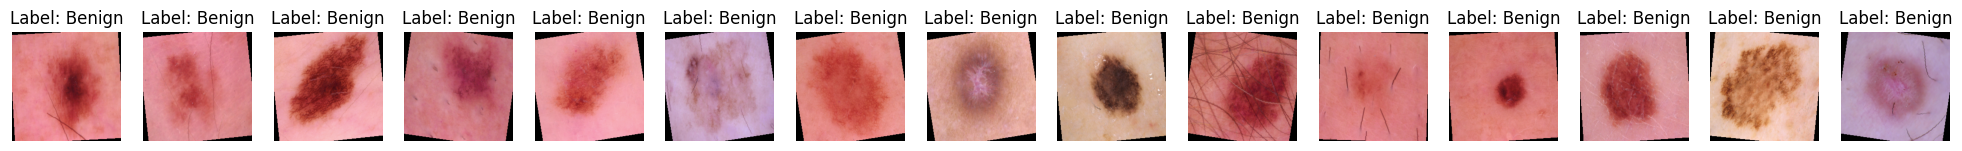

In [12]:
def inverse_normalize(tensor, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    tensor = tensor * std + mean  # Reverse normalization
    tensor = torch.clamp(tensor, 0, 1)  # Clamp values to [0, 1] for display
    return tensor

mean=[0.7630, 0.5457, 0.5703]
std=[0.0875, 0.1164, 0.1309]

fig, axes = plt.subplots(1, 15, figsize=(25, 8))
for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    denormalized_image = inverse_normalize(image, mean, std)
    ax.imshow(denormalized_image.permute(1, 2, 0))  # Convert to HWC for matplotlib
    ax.set_title(f"Label: {'Benign' if label == 0 else 'Malignant'}")
    ax.axis("off")

# **MODEL ARCHITECTURE**

In [14]:
class NeuralNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*26*26, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# **LOAD OWN MODEL vs RESNET18 MODEL**

In [15]:
model = NeuralNet()

In [ ]:
# DONT RUN BOTH CELLS ALTERNATIVELY

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)  # ONLY LOAD LATER FOR COMPARISON
model.fc = nn.Linear(512, 2)  # ADJUST OUTPUT FOR 2 CLASSES

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [16]:
model

NeuralNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=43264, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
count_parameters(model)

5224454

# **DEFINE LOSS FUNCTION AND OPTIMIZER**

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# **TRAINING AND VALIDATION LOOP**

In [ ]:
# Function to test the model with the test dataset and print the accuracy for the test images
def validation():

    model.eval()
    running_loss = 0.0
    accuracy = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            labels = labels.to(device)
            images = images.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            loss = criterion(outputs, labels).item()
            running_loss += loss

    # compute the accuracy over all test images

    accuracy = (100 * accuracy / total)
    running_loss = running_loss / len(val_loader)
    return running_loss, accuracy


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    val_losses = []
    val_accuracies = []
    train_losses = []
    train_accuracies = []


    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        total = 0.0

        for i, (images, labels) in enumerate(train_loader):

            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            running_acc += (predicted == labels).sum().item()
            total += labels.size(0)

            running_loss += loss.item()

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        loss, accuracy = validation()

        val_losses.append(loss)
        val_accuracies.append(accuracy)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * running_acc / total)

        print(f'Epoch:{epoch+1}   VAL ACC:{accuracy}   VAL LOSS: {loss}')
        print(f'Epoch:{epoch+1}   TRAIN ACC:{100 * running_acc / total}  TRAIN LOSS: {running_loss / len(train_loader)}')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='green')
    plt.plot(val_accuracies, label='Validation Accuracy', color='red')
    plt.title('Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# **TESTING LOOP**

In [ ]:
def test():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # Run the model on the test set
            outputs = model(images)

            # Get the predictions
            _, predicted = torch.max(outputs, 1)

            # Collect predictions and true labels for metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)

    # Display confusion matrix using a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report (precision, recall, F1-score)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))

# **ACTUAL TRAINING + VALIDATION**

Epoch:1   VAL ACC:90.44665012406948   VAL LOSS: 0.22657647877931594
Epoch:1   TRAIN ACC:87.8221034548578  TRAIN LOSS: 0.27227667664609306
Epoch:2   VAL ACC:69.43755169561621   VAL LOSS: 0.6082974195480346
Epoch:2   TRAIN ACC:54.38060698606604  TRAIN LOSS: 0.7954845770103175
Epoch:3   VAL ACC:85.64929693961952   VAL LOSS: 0.34480448067188263
Epoch:3   TRAIN ACC:80.60698606604313  TRAIN LOSS: 0.44270212548535043
Epoch:4   VAL ACC:83.45740281224153   VAL LOSS: 0.34156441390514375
Epoch:4   TRAIN ACC:84.87306737927085  TRAIN LOSS: 0.31848510045830797
Epoch:5   VAL ACC:87.34491315136476   VAL LOSS: 0.26380822956562044
Epoch:5   TRAIN ACC:85.82744798625691  TRAIN LOSS: 0.28890669491232895
Epoch:6   VAL ACC:87.38626964433416   VAL LOSS: 0.271521720290184
Epoch:6   TRAIN ACC:86.38098873830884  TRAIN LOSS: 0.2691971059979462
Epoch:7   VAL ACC:86.39371381306866   VAL LOSS: 0.2589813098311424
Epoch:7   TRAIN ACC:86.72456575682382  TRAIN LOSS: 0.26010316828402075
Epoch:8   VAL ACC:87.4689826302729

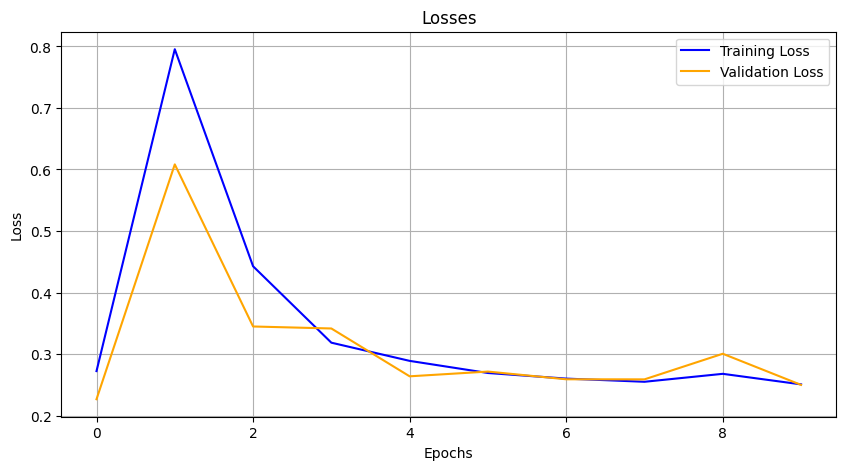

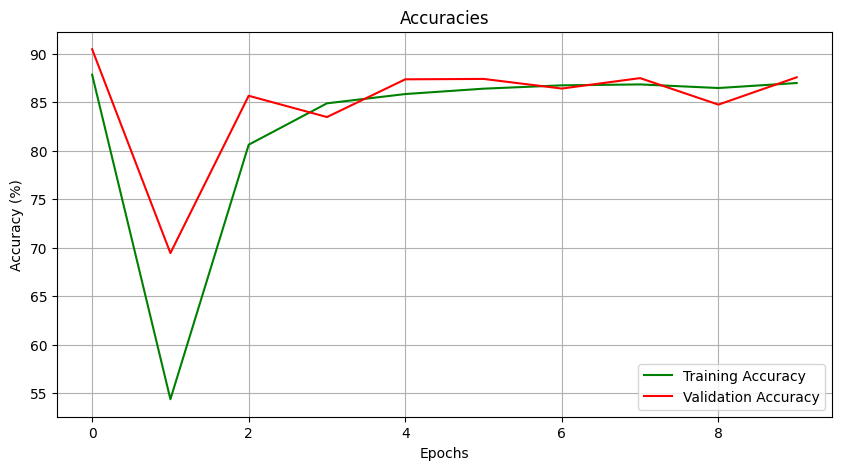

In [ ]:
epochs = 10

train(epochs)

# **ACTUAL TESTING**

Test Accuracy: 89.80%
Confusion Matrix:
[[1529   84]
 [ 245 1368]]


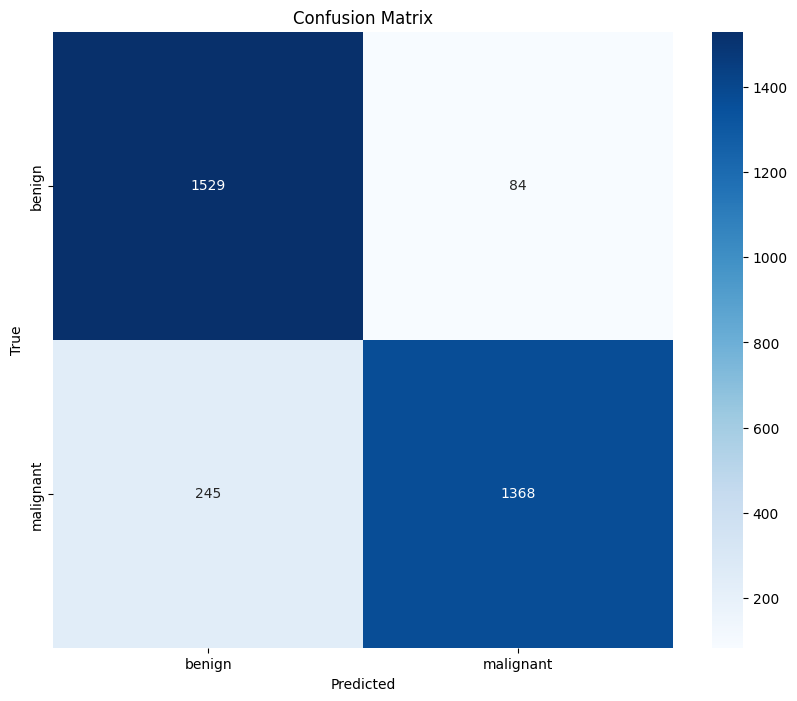


Classification Report:
              precision    recall  f1-score   support

      benign       0.86      0.95      0.90      1613
   malignant       0.94      0.85      0.89      1613

    accuracy                           0.90      3226
   macro avg       0.90      0.90      0.90      3226
weighted avg       0.90      0.90      0.90      3226



In [ ]:
class_names = ['benign', 'malignant']
test()

# **SAVING AND LOADING THE MODEL**

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [21]:
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))

FileNotFoundError: [Errno 2] No such file or directory: 'model_weights.pth'

# **GRADCAM FOR VISUALIZING THE DECISION MAKING**

<Figure size 1500x800 with 0 Axes>

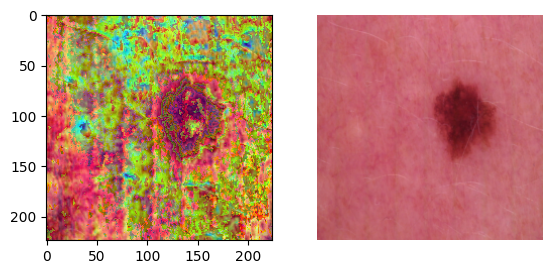

In [27]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, image_tensor, class_idx=None):
        self.model.eval()
        image_tensor.requires_grad_()

        # Forward pass
        output = self.model(image_tensor)

        # Use top predicted class if no class_idx is specified
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Target output for the specified class
        target_output = output[:, class_idx]

        # Backward pass to compute gradients
        self.model.zero_grad()
        target_output.backward()

        # Compute the Grad-CAM heatmap
        gradients = self.gradients.clone().detach()
        activations = self.activations.clone().detach()

        # Global average pooling of gradients
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # Weight activations by gradients
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        # Compute the heatmap
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.cpu().numpy()


# Function to overlay the heatmap on the original image
def overlay_heatmap(heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)
    overlayed_image = cv2.addWeighted(heatmap_colored, alpha, image, 1 - alpha, 0)
    return overlayed_image


# Example usage
# Assuming `model` is your trained model and `test_dataset` contains your test images

# Select device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model = model.to(device)

# Define the target layer
target_layer = model.conv2  # Replace with the correct layer in your model

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Prepare the image tensor
new_image = test_dataset[82][0]
image_tensor = new_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Generate Grad-CAM heatmap
heatmap = grad_cam.generate(image_tensor)

# Convert tensor to numpy image for visualization
image_numpy = image_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy()
image_numpy = (image_numpy * 255).astype(np.uint8)

# Overlay heatmap on the original image
overlayed_image = overlay_heatmap(heatmap, image_numpy)

# Display the image
plt.figure(figsize=(15,8))
f, axarr = plt.subplots(1,2)
axarr[0].imshow(overlayed_image)
axarr[1].imshow(np.transpose(inverse_normalize(new_image, mean, std), (1, 2, 0)))
plt.axis('off')
plt.show()
